In [401]:
!pip3 install pandas numpy seaborn kaggle matplotlib scikit-learn

In [402]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Obtener los datos

In [403]:
from pathlib import Path
import shutil

# Cargar el archivo kaggle.json para autenticación con la API de Kaggle

# Suponiendo que kaggle.json está en el directorio actual
kaggle_json = Path('kaggle.json')
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
shutil.copy(str(kaggle_json), str(kaggle_dir / 'kaggle.json'))

# Establecer permisos adecuados
os.chmod(str(kaggle_dir / 'kaggle.json'), 0o600)

In [404]:
!kaggle datasets download -d neuromusic/avocado-prices -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/neuromusic/avocado-prices
License(s): ODbL-1.0
  0%|                                                | 0.00/629k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 629k/629k [00:00<00:00, 1.30GB/s]


In [405]:
df = pd.read_csv("./avocado.csv")
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Estandarizacion y eliminacion de columnas

In [406]:

df.drop(columns=['Unnamed: 0'], inplace=True)

df.rename(columns={
    '4046': 'small_hass_sold',
    '4225': 'large_hass_sold',
    '4770': 'xlarge_hass_sold',
    'AveragePrice': 'averageprice',
    'Total Volume': 'total_volume',
    'Total Bags': 'total_bags',
    'Small Bags': 'small_bags',
    'Large Bags': 'large_bags',
    'XLarge Bags': 'xlarge_bags',
    'Date': 'date',
}, inplace=True)

# Tratamiento de valores nulos

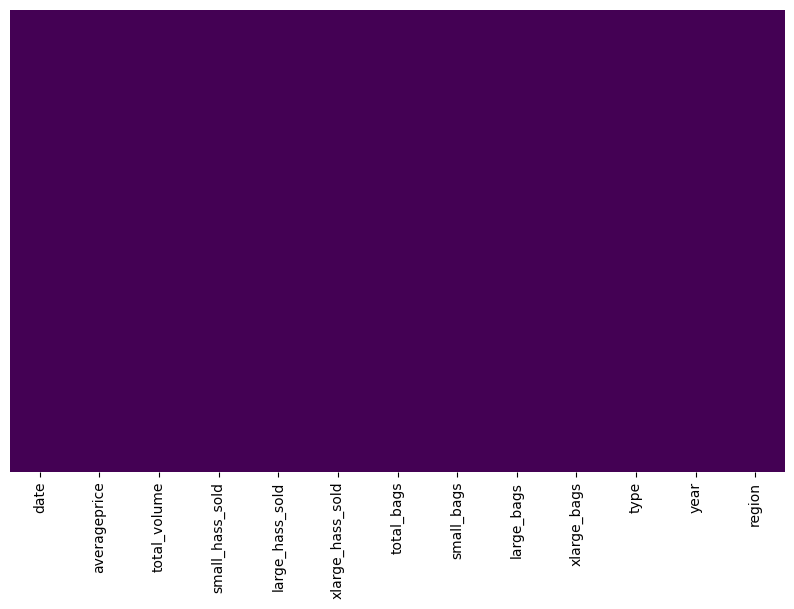

In [407]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.show()

# Tratamiento de valores atipicos

In [408]:
numeric_cols = [
    'averageprice', 'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags'
]


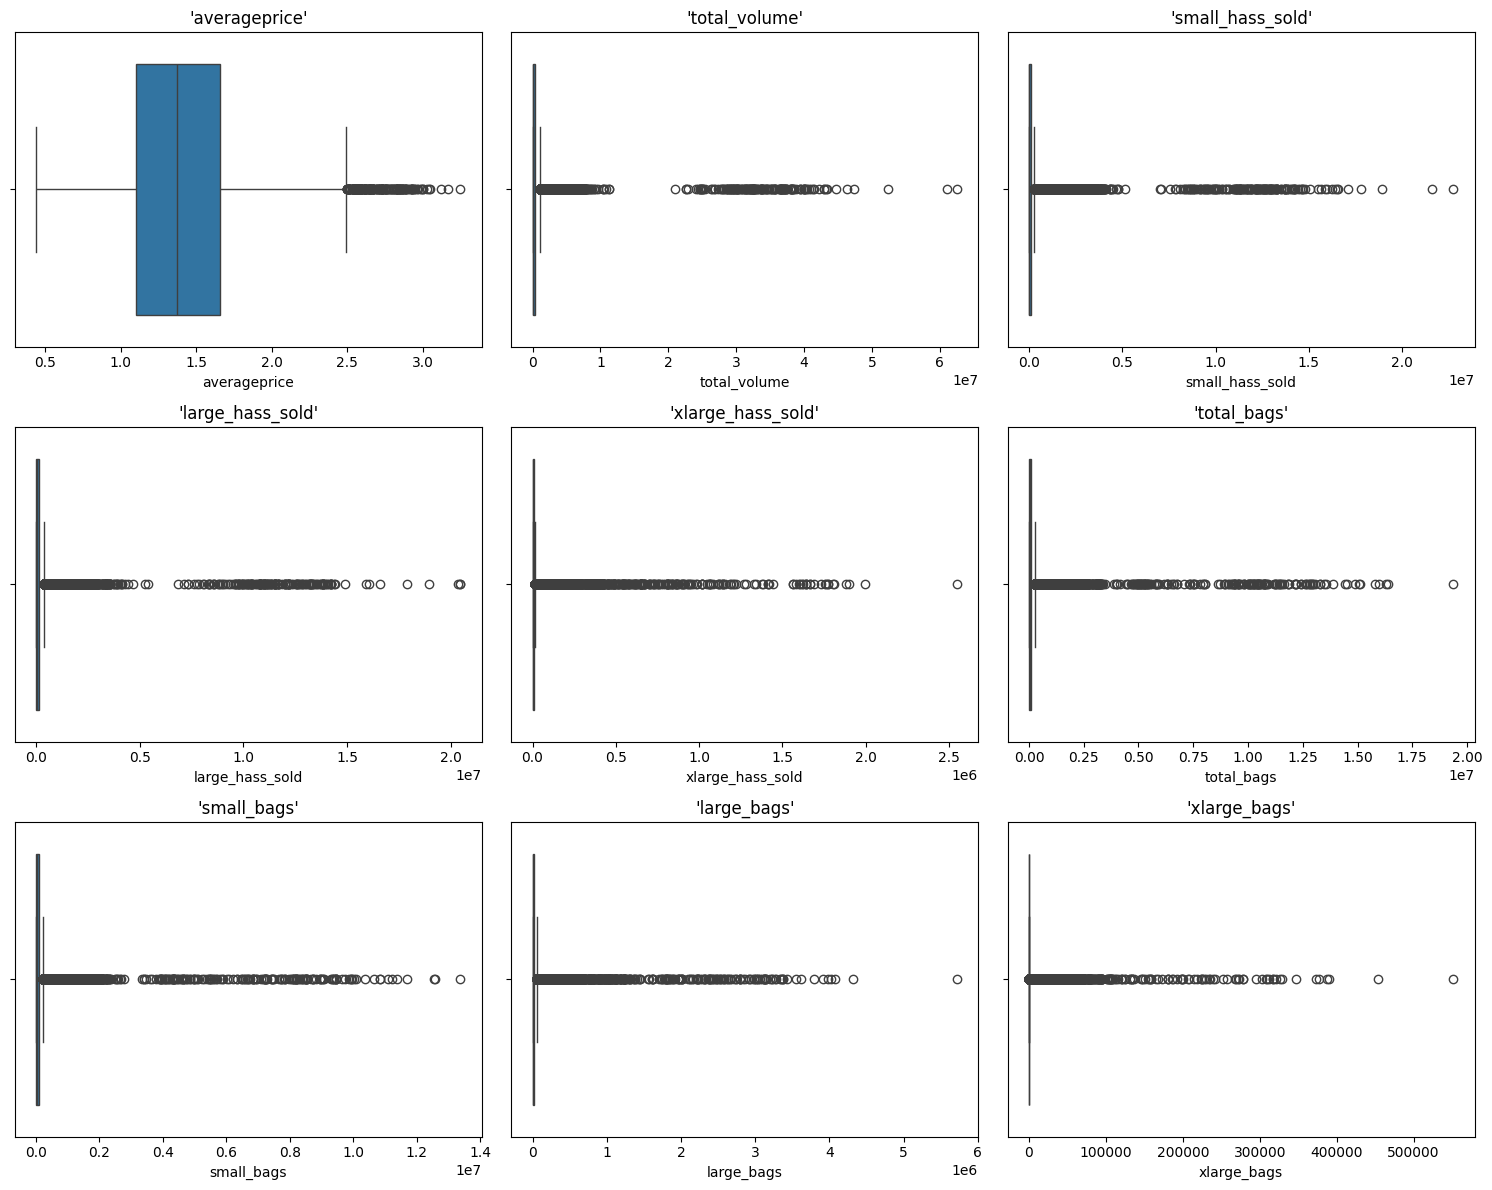

In [409]:
n = len(numeric_cols)
ncols = 3 
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Crear un boxplot por cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"'{col}'", fontsize=12)
    axes[i].set_xlabel(col)

# Eliminar ejes vacíos si sobran subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Detectar outliers

In [410]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outlier_counts = outliers.sum().sort_values(ascending=False)

print(outlier_counts)

xlarge_bags         4014
xlarge_hass_sold    2918
large_bags          2707
total_bags          2533
large_hass_sold     2519
small_hass_sold     2518
small_bags          2407
total_volume        2297
averageprice         209
dtype: int64


## Analizar distribucion de los datos

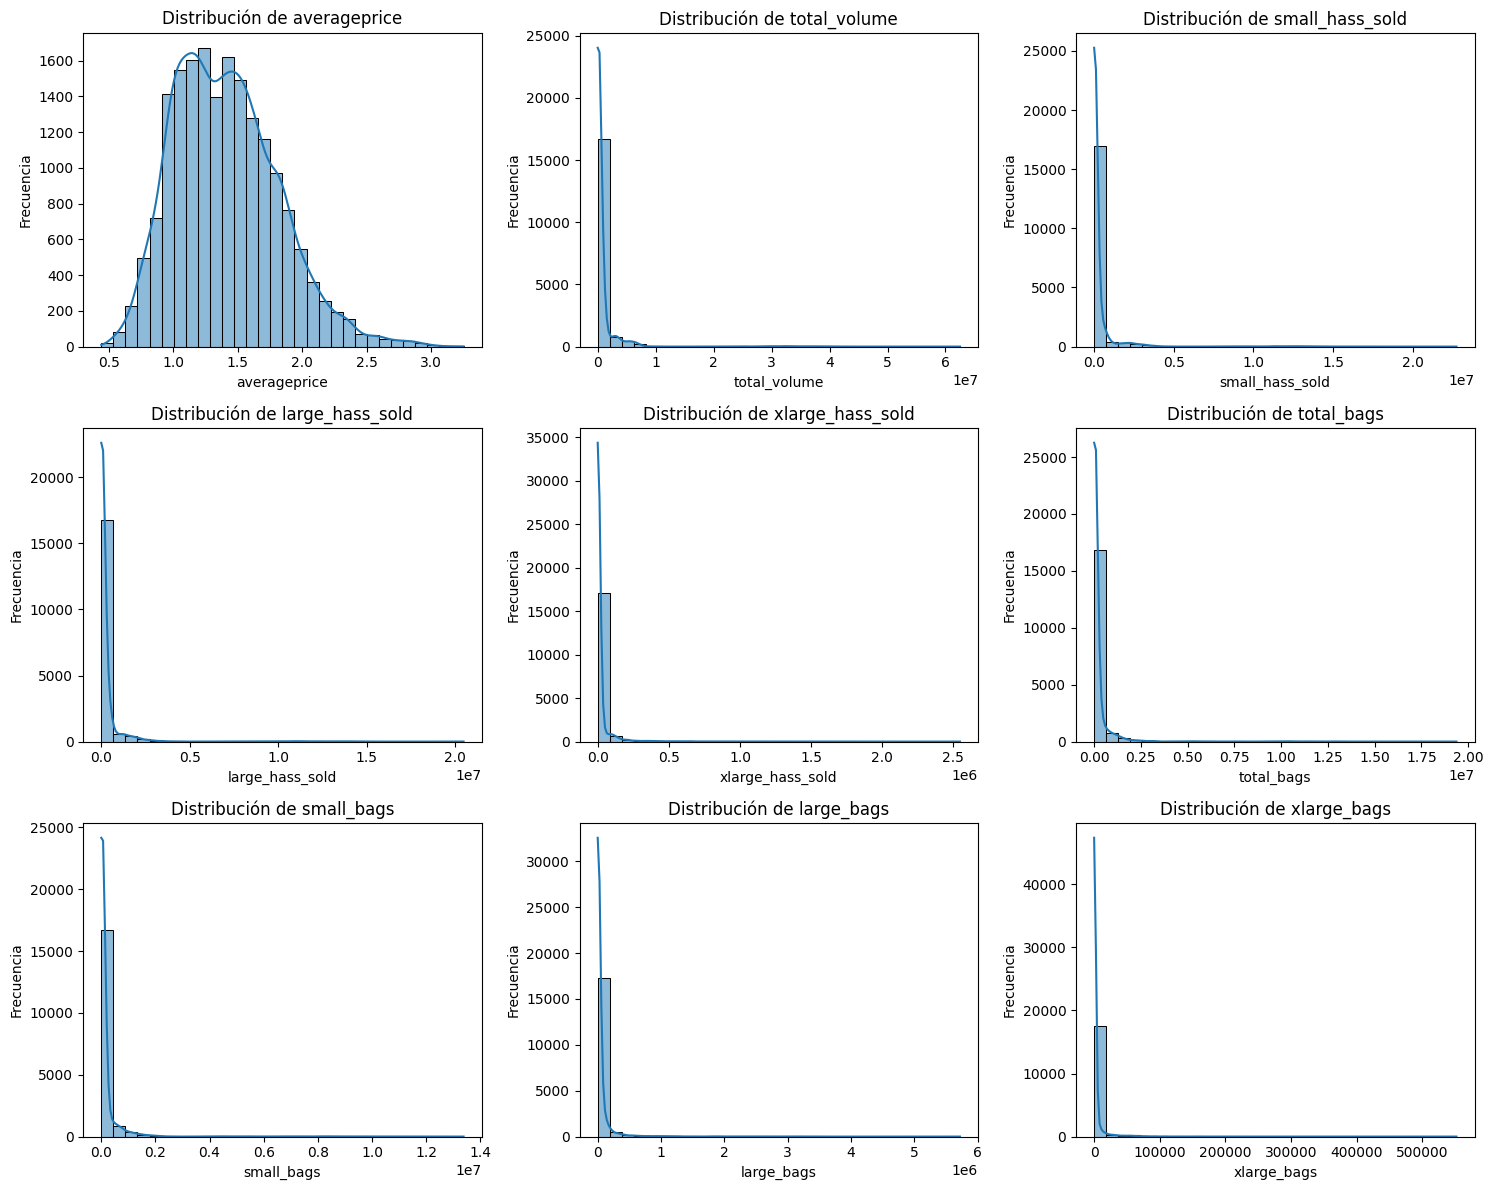

In [411]:
n = len(numeric_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols  # calcula filas necesarias

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()



## Reemplazo de outliers

In [412]:

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if col == 'averageprice':
        # reemplazar los datos atípicos por el promedio
        df.loc[df[col] < lower, col] = df[col].mean()
        df.loc[df[col] > upper, col] = df[col].mean()
    else:
        # Reemplazar atípicos por la mediana
        df.loc[df[col] < lower, col] = df[col].mean()
        df.loc[df[col] > upper, col] = df[col].mean()
df[numeric_cols].describe()





,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags
count,18249.000000,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000
mean,1.391139,2.618605e+05,71834.860378,88243.981595,5077.691201,73823.146701,54590.436666,14243.641741,693.352325
std,0.377411,3.162123e+05,104105.458735,112727.412727,8366.464606,84746.479806,63776.045652,20062.667173,1282.080311
min,0.440000,8.456000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000,1.083858e+04,854.070000,3008.780000,0.000000,5088.640000,2849.420000,127.470000,0.000000
50%,1.370000,1.073768e+05,8645.300000,29061.020000,184.990000,39743.830000,26362.820000,2647.710000,0.000000
75%,1.650000,4.329623e+05,111020.200000,150206.860000,6243.420000,110783.370000,83337.670000,22029.250000,132.500000
max,2.490000,1.063584e+06,293008.424531,370026.960000,22839.735993,269169.000000,204056.330000,54855.780000,3106.426507


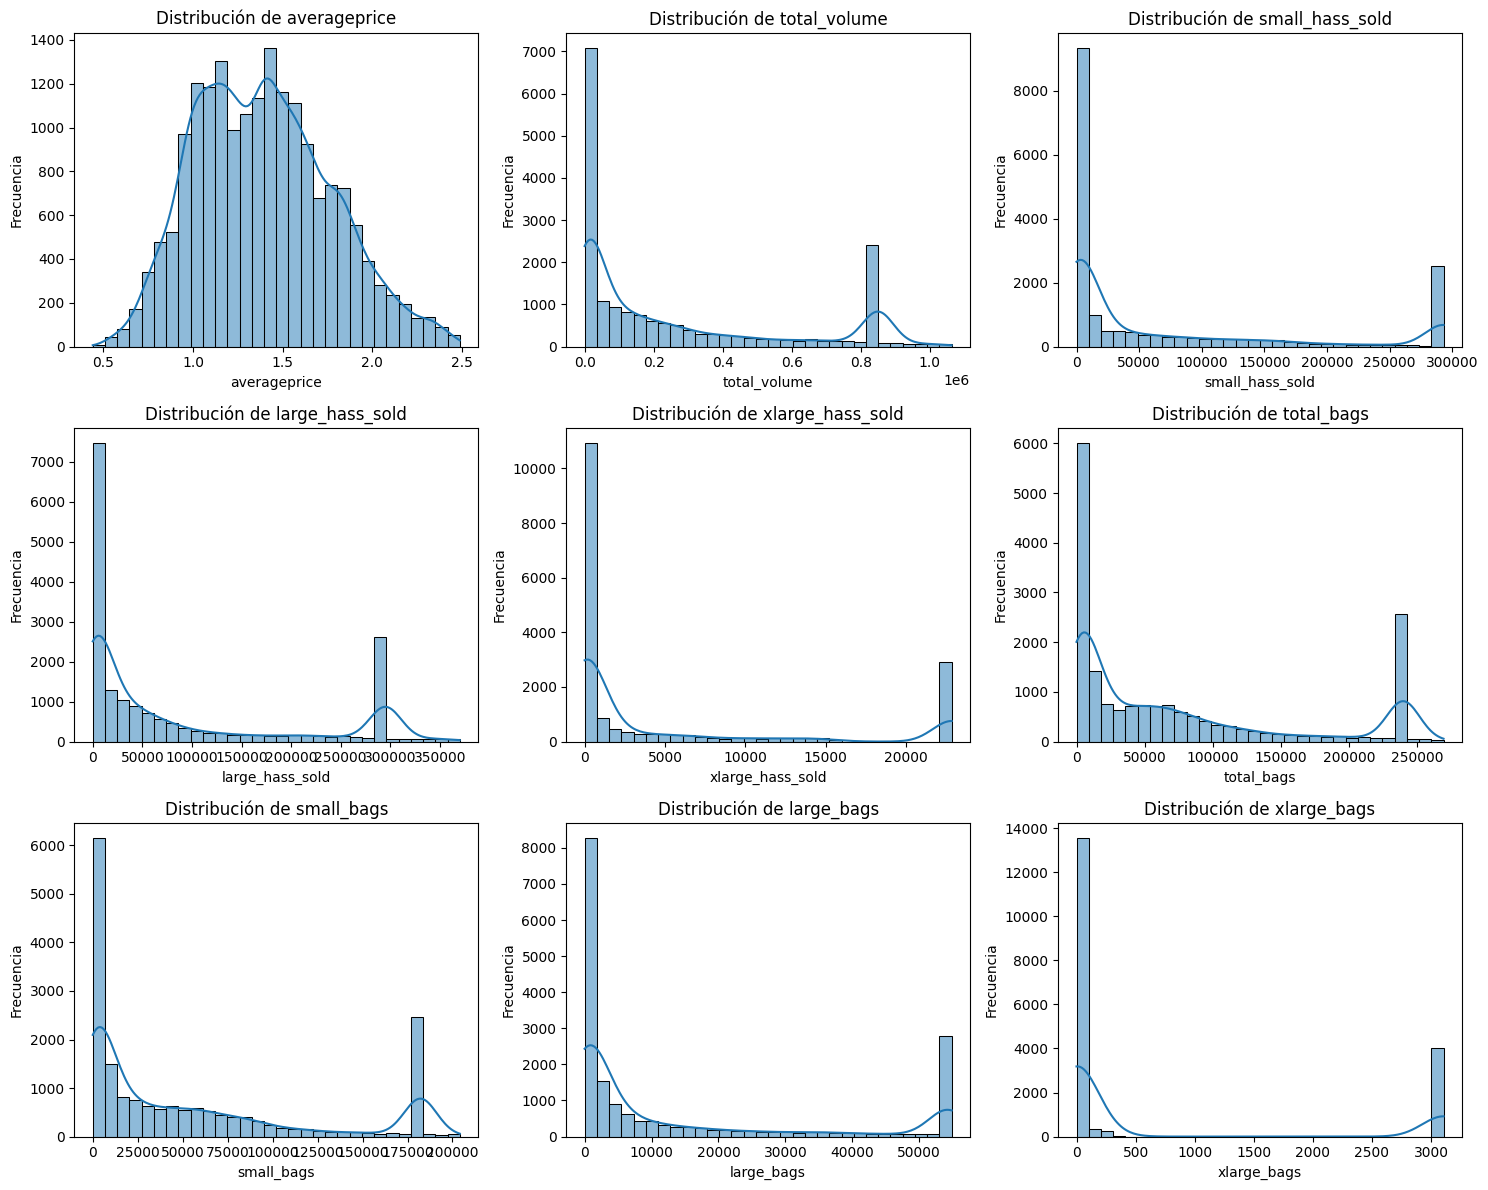

In [413]:
n = len(numeric_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols  # calcula filas necesarias

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


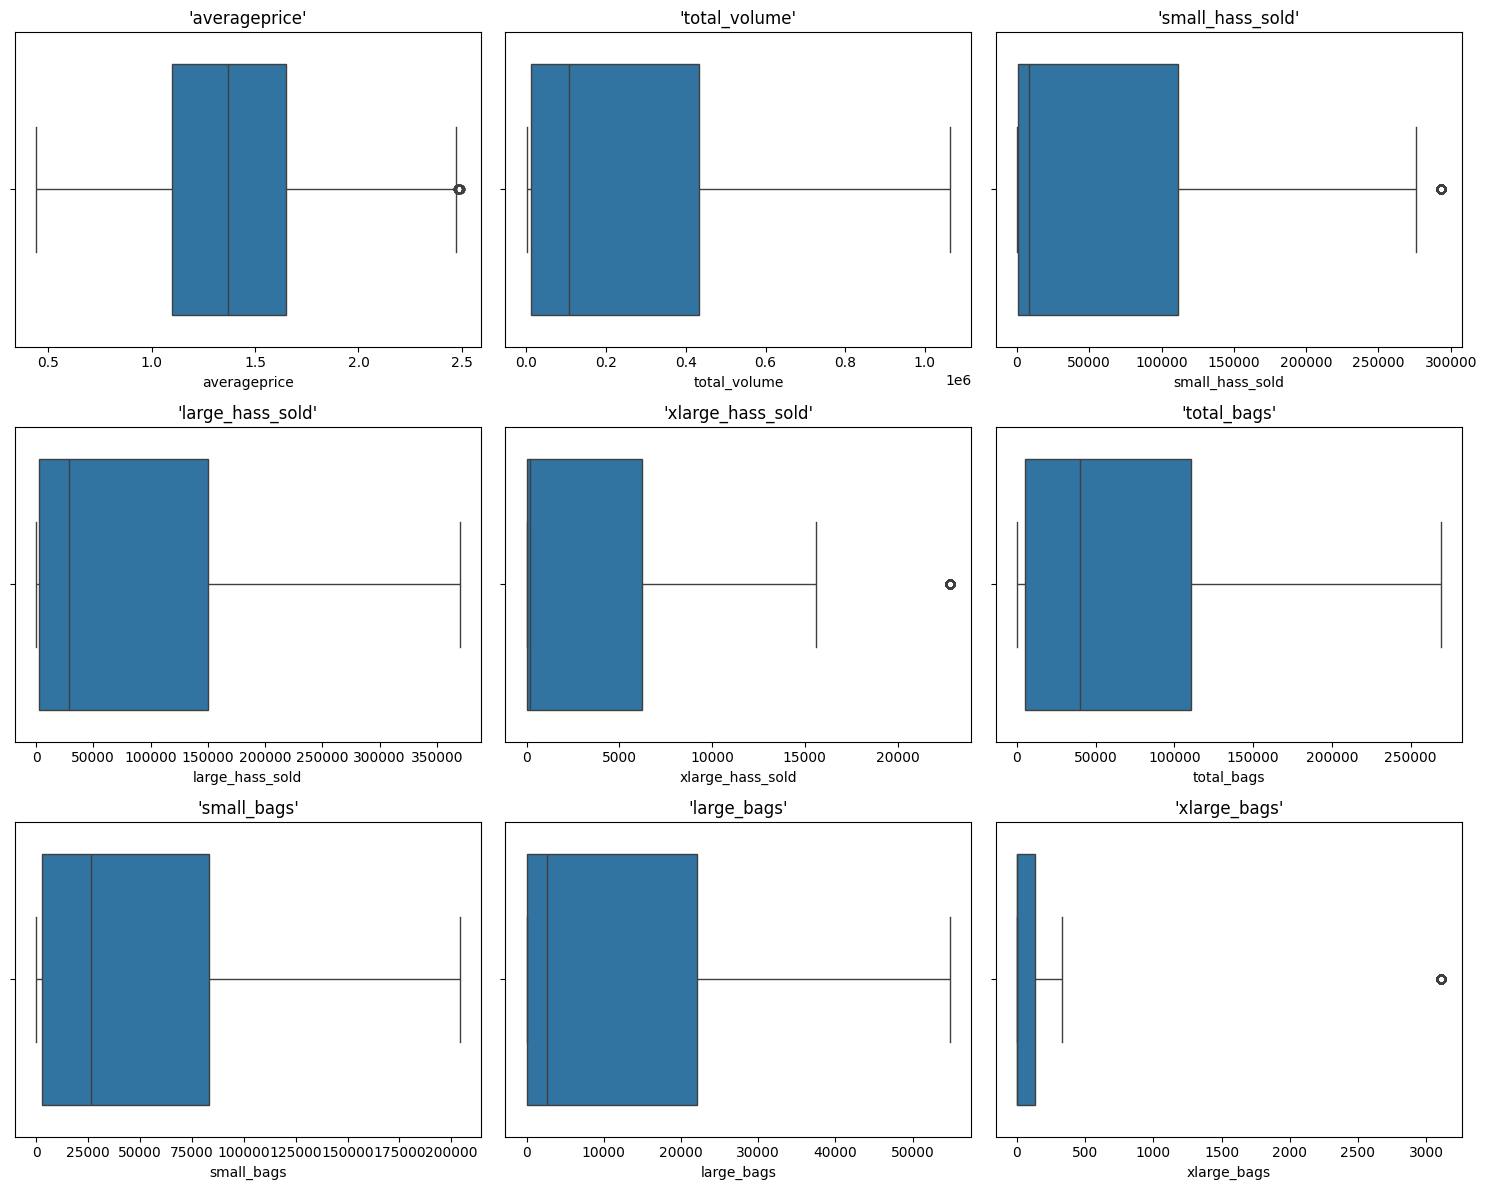

In [414]:
n = len(numeric_cols)
ncols = 3  # número de columnas de gráficos por fila (ajústalo según tu gusto)
nrows = (n + ncols - 1) // ncols  # calcula el número de filas necesarias

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()  # convertir a lista para iterar fácilmente

# Crear un boxplot por cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"'{col}'", fontsize=12)
    axes[i].set_xlabel(col)

# Eliminar ejes vacíos si sobran subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Manejo de columnas categoricas y fechas

In [415]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
# Eliminar la columna 'date' si no es necesaria
df.drop(columns=['date'], inplace=True)

# Estandarizacion de los datos

In [416]:
cols_to_scale = [
   'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'year', 'month', 'day'
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

## Caso especial de la columna region

In [417]:
df_train, df_test = train_test_split(df_scaled, test_size=0.3, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

TARGET_COLUMN = 'averageprice'
FEATURE_COLUMN = 'region'
N_FOLDS = 5

# Inicializar un array para almacenar los encodings del entrenamiento
oof_encoded_features = []

# Inicializar KFold
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 1. Iterar sobre los folds del conjunto de entrenamiento
for train_index, val_index in kf.split(df_train):
    X_train_fold, X_val_fold = df_train.loc[train_index], df_train.loc[val_index]

    # Calcular la media (Target Encoding) SOLO con el fold de entrenamiento
    target_mean_map = X_train_fold.groupby(FEATURE_COLUMN)[TARGET_COLUMN].mean()

    # Mapear la media al fold de validación
    encoded_values = X_val_fold[FEATURE_COLUMN].map(target_mean_map)

    # Almacenar los resultados
    oof_encoded_features.append(encoded_values)

# 2. Recombinar los resultados de los folds para obtener la columna de entrenamiento final
df_train[f'{FEATURE_COLUMN}_encoded'] = pd.concat(oof_encoded_features).sort_index()


# 1. Calcular la media global (el Target Encoding) usando TODO el conjunto de entrenamiento
global_target_mean_map = df_train.groupby(FEATURE_COLUMN)[TARGET_COLUMN].mean()

# 2. Calcular la media general de todo el target (para las regiones no vistas)
global_mean = df_train[TARGET_COLUMN].mean()

# 3. Aplicar el mapeo al conjunto de prueba
df_test[f'{FEATURE_COLUMN}_encoded'] = df_test[FEATURE_COLUMN].map(global_target_mean_map)

# 4. Manejar categorías no vistas (Regiones que están en Test pero no en Train)
# Rellenamos los NaNs con la media general del target del entrenamiento.
df_test[f'{FEATURE_COLUMN}_encoded'].fillna(global_mean, inplace=True)

# Eliminar la columna original 'region' si no es necesaria
df_train.drop(columns=[FEATURE_COLUMN], inplace=True)
df_test.drop(columns=[FEATURE_COLUMN], inplace=True)



/tmp/ipykernel_5536/1436760889.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[f'{FEATURE_COLUMN}_encoded'].fillna(global_mean, inplace=True)


In [418]:
df_train.head()

,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags,year,type_organic,month,day,region_encoded
0,0.95,1.862039,2.124573,1.812542,0.118170,1.956667,2.000873,1.998515,-0.481015,1.970504,False,-1.464959,-0.189449,1.052116
1,1.14,-0.562698,-0.453582,-0.638809,-0.329471,-0.390133,-0.216876,-0.709977,-0.538961,-0.157353,False,0.515780,-0.189449,1.360164
2,1.17,0.018804,0.165685,-0.074864,-0.388089,0.274525,0.564018,-0.572536,1.882207,0.906575,False,0.232818,0.038444,1.292935
3,0.99,1.862039,2.124573,1.835545,2.123063,1.956667,2.000873,1.998515,-0.497371,-1.221282,False,0.232818,-1.214968,1.406124
4,1.58,-0.784443,-0.628270,-0.744684,-0.606927,-0.834710,-0.812960,-0.692937,-0.540817,-1.221282,True,0.232818,-1.214968,1.245366


# Implementacion de los modelos

## Division de los datos

In [419]:
x_train = df_train.drop(columns=[TARGET_COLUMN])
y_train = df_train[TARGET_COLUMN]
x_test = df_test.drop(columns=[TARGET_COLUMN])
y_test = df_test[TARGET_COLUMN]

## Implementacion modelo random forest

In [420]:
rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf.fit(x_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [421]:
y_pred_rf = rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R^2 Score: {r2_rf}")



Random Forest Regressor Metrics:
Mean Squared Error: 0.017916778006223915
Mean Absolute Error: 0.0929410329512366
R^2 Score: 0.8731609608481917


<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5536/1931886663.py:25: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)


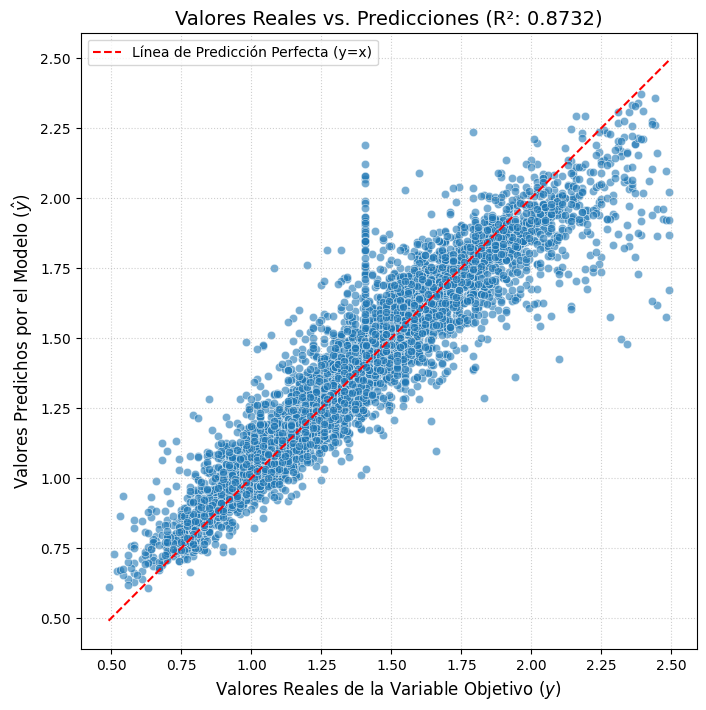

In [424]:
# Crear un DataFrame para facilitar el uso con Seaborn (opcional, pero limpio)
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_rf)': y_pred_rf})

# Calcular el R^2 para mostrarlo en el gráfico
r2 = r2_score(y_test, y_pred_rf)

# Crear el gráfico
plt.figure(figsize=(8, 8))

# a) Dibujar los puntos de dispersión (scatter plot)
sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_rf)', data=plot_df, alpha=0.6)

# b) Dibujar la línea de identidad (y=x)
# Usamos el mínimo y máximo de los datos para definir los límites de la línea
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

# c) Añadir títulos y etiquetas
plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Hace los ejes cuadrados para ver mejor la pendiente
plt.show()

## Implementacion modelo GradientBoosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(x_train, y_train)

In [ ]:
y_pred_gb = gb.predict(x_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor Metrics:")
print(f"Mean Squared Error: {mse_gb}")
print(f"Mean Absolute Error: {mae_gb}")
print(f"R^2 Score: {r2_gb}")


In [ ]:
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_gb)': y_pred_gb})

r2 = r2_score(y_test, y_pred_gb)

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_gb)', data=plot_df, alpha=0.6)

min_val = min(y_test.min(), y_pred_gb.min())
max_val = max(y_test.max(), y_pred_gb.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Implementacion modelo MLP

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(x_train, y_train)

In [ ]:
y_pred_mlp = mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regressor Metrics:")
print(f"Mean Squared Error: {mse_mlp}")
print(f"Mean Absolute Error: {mae_mlp}")
print(f"R^2 Score: {r2_mlp}")

In [ ]:
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_mlp)': y_pred_mlp})

r2 = r2_score(y_test, y_pred_mlp)

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_mlp)', data=plot_df, alpha=0.6)

min_val = min(y_test.min(), y_pred_mlp.min())
max_val = max(y_test.max(), y_pred_mlp.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()